<a href="https://colab.research.google.com/github/rafael2673/AEDII/blob/main/U2T3/trabalho_7_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install osmnx

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.6/99.6 kB 3.4 MB/s eta 0:00:00


In [2]:
import osmnx as ox
import networkx as nx
import matplotlib.pyplot as plt

In [3]:
def to_undirected_multigraph(G):
    """
    Converte um MultiDiGraph direcionado em um MultiGraph não-direcionado,
    preservando atributos dos nós e arestas.
    """
    H = nx.MultiGraph()
    # Copiar nós e seus atributos
    for n, data in G.nodes(data=True):
        H.add_node(n, **data)

    # Copiar arestas e seus atributos, sem direcionamento
    for u, v, data in G.edges(data=True):
        # Em um MultiGraph, se já existir uma aresta u-v, esta será adicionada como mais uma aresta paralela
        H.add_edge(u, v, **data)

    # Copiar atributos do grafo
    H.graph.update(G.graph)
    return H

In [4]:
# ============================================
# 1. Obter o grafo da cidade de Natal
# ============================================
place = "Natal, Rio Grande do Norte, Brazil"
G = ox.graph_from_place(place, network_type='drive')

# Converte para não-direcionado mantendo o tipo MultiGraph
G_undirected = to_undirected_multigraph(G)

In [5]:
# ============================================
# 2. Obter POIs de interesse (hospitais como exemplo)
# ============================================
tags = {'amenity': 'hospital'}
pois = ox.features.features_from_place(place, tags=tags)

# Extrair pontos representativos (centroides se for polígono)
hospital_points = []
for idx, row in pois.iterrows():
    if row.geometry.geom_type == 'Point':
        hospital_points.append((row.geometry.y, row.geometry.x))
    else:
        hospital_points.append((row.geometry.centroid.y, row.geometry.centroid.x))

if not hospital_points:
    print("Nenhum hospital encontrado. Tentando escolas...")
    tags = {'amenity': 'school'}
    pois = ox.features.features_from_place(place, tags=tags)
    for idx, row in pois.iterrows():
        if row.geometry.geom_type == 'Point':
            hospital_points.append((row.geometry.y, row.geometry.x))
        else:
            hospital_points.append((row.geometry.centroid.y, row.geometry.centroid.x))
    if not hospital_points:
        raise ValueError("Nenhum POI encontrado para as categorias tentadas.")

In [6]:
# ============================================
# 3. Encontrar nós mais próximos dos POIs
# ============================================
latitudes = [hp[0] for hp in hospital_points]
longitudes = [hp[1] for hp in hospital_points]
hospital_nodes = ox.distance.nearest_nodes(G_undirected, X=longitudes, Y=latitudes)
hospital_nodes = list(set(hospital_nodes))

if len(hospital_nodes) < 2:
    raise ValueError("POIs insuficientes para criar um MST (menos de 2 pontos).")

# ============================================
# 4. Construir um grafo completo com menor rota entre POIs
# ============================================
G_interest = nx.Graph()
for i in range(len(hospital_nodes)):
    for j in range(i+1, len(hospital_nodes)):
        route = nx.shortest_path(G_undirected, hospital_nodes[i], hospital_nodes[j], weight='length')
        route_length = 0
        for k in range(len(route)-1):
            route_length += G_undirected[route[k]][route[k+1]][0]['length']  # Como é MultiGraph, usar [0]
        G_interest.add_edge(hospital_nodes[i], hospital_nodes[j], weight=route_length)

# ============================================
# 5. Calcular o MST
# ============================================
mst_edges = list(nx.minimum_spanning_edges(G_interest, data=True))
total_mst_length = sum([d['weight'] for (u, v, d) in mst_edges])
print("Comprimento total do MST entre os POIs selecionados:", total_mst_length, "metros")

Comprimento total do MST entre os POIs selecionados: 46270.572254595536 metros


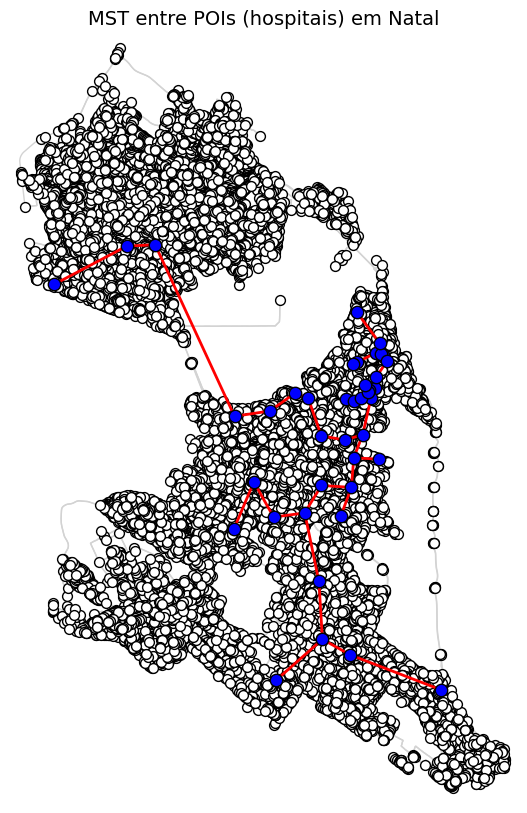

In [8]:
# Supondo que você já tenha as variáveis:
# G_undirected: grafo MultiGraph não-direcionado
# hospital_nodes: lista de nós próximos aos hospitais
# mst_routes: lista de rotas do MST (cada rota é uma lista de nós)
# latitudes, longitudes: listas com lat/long dos hospitais

# Caso não tenha sido definido, você pode calcular um bbox se quiser
# bbox_padding = 0.02
# north = max(latitudes) + bbox_padding
# south = min(latitudes) - bbox_padding
# east = max(longitudes) + bbox_padding
# west = min(longitudes) - bbox_padding

mst_routes = []
for u, v, data in mst_edges:
    mst_routes.append([u, v]) # Each route is simply the two nodes of the edge

# Plotar o grafo base
fig, ax = ox.plot_graph(
    G_undirected,
    # Caso queira o bbox, descomente a linha abaixo:
    # bbox=(north, south, east, west),
    show=False,
    close=False,
    node_color='white',
    node_edgecolor='black',
    node_size=50,
    edge_color='lightgray',
    edge_linewidth=1,
    bgcolor='white',    # fundo branco
    figsize=(10,10)
)

# Destacar as rotas do MST em vermelho
for route in mst_routes:
    x = [G_undirected.nodes[n]['x'] for n in route]
    y = [G_undirected.nodes[n]['y'] for n in route]
    ax.plot(x, y, color='red', linewidth=2, zorder=4)

# Plotar também os POIs (hospitais) em azul
poi_x = [G_undirected.nodes[n]['x'] for n in hospital_nodes]
poi_y = [G_undirected.nodes[n]['y'] for n in hospital_nodes]
ax.scatter(poi_x, poi_y, c='blue', s=80, zorder=5, edgecolor='black')

plt.title("MST entre POIs (hospitais) em Natal", fontsize=14)
plt.show()

Comprimento total do MST entre os POIs selecionados: 46.270572254595535 quilômetros
Comprimento total da rede não otimizada (sequencial) entre os POIs: 206.36383394838762 quilômetros


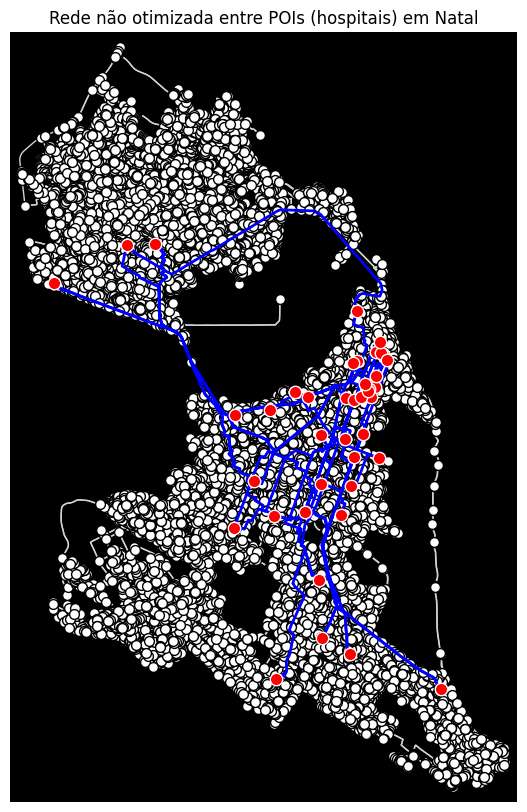

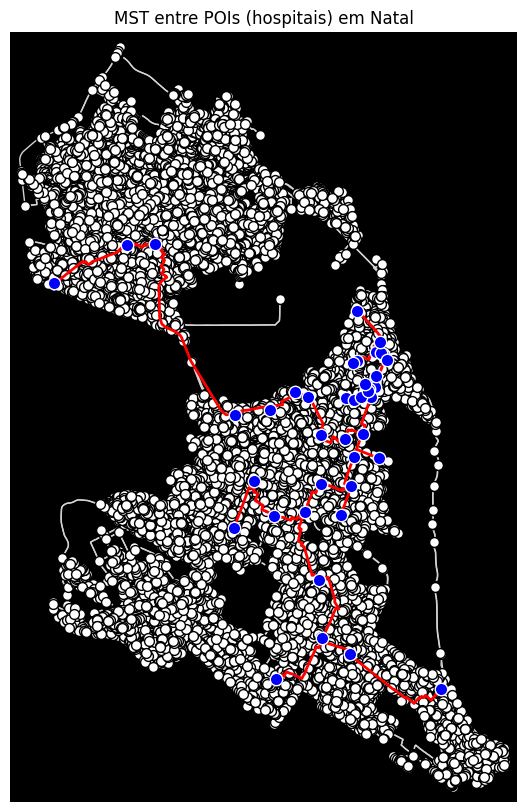

In [14]:
import osmnx as ox
import networkx as nx
import matplotlib.pyplot as plt

# =========================================================
# Construir um grafo completo com menor rota entre POIs
# =========================================================
G_interest = nx.Graph()
for i in range(len(hospital_nodes)):
    for j in range(i + 1, len(hospital_nodes)):
        route = nx.shortest_path(G_undirected, hospital_nodes[i], hospital_nodes[j], weight='length')
        route_length = 0
        for k in range(len(route) - 1):
            route_length += G_undirected[route[k]][route[k + 1]][0]['length']
        G_interest.add_edge(hospital_nodes[i], hospital_nodes[j], weight=route_length)

# =========================================================
# Calcular o MST
# =========================================================
mst_edges = list(nx.minimum_spanning_edges(G_interest, data=True))
total_mst_length = sum([d['weight'] for (u, v, d) in mst_edges])
total_mst_length_km = total_mst_length / 1000  # Converter de metros para quilômetros
print("Comprimento total do MST entre os POIs selecionados:", total_mst_length_km, "quilômetros")

# =========================================================
# Calcular a Rede Não Otimizada (Sequencial)
# =========================================================
total_seq_length = 0
for i in range(len(hospital_nodes) - 1):
    route = nx.shortest_path(G_undirected, hospital_nodes[i], hospital_nodes[i + 1], weight='length')
    route_length = 0
    for k in range(len(route) - 1):
        route_length += G_undirected[route[k]][route[k + 1]][0]['length']
    total_seq_length += route_length
total_seq_length_km = total_seq_length / 1000  # Converter de metros para quilômetros
print("Comprimento total da rede não otimizada (sequencial) entre os POIs:", total_seq_length_km, "quilômetros")

# =========================================================
# Visualizar o Grafo e as Conexões
# =========================================================
# Plotar o grafo base com fundo preto (Rede Não Otimizada)
fig2, ax2 = ox.plot_graph(
    G_undirected,
    show=False,
    close=False,
    node_color='white',
    node_edgecolor='black',
    node_size=50,
    edge_color='lightgray',
    edge_linewidth=1,
    bgcolor='black',
    figsize=(10, 10)
)

# Destacar as rotas da rede não otimizada em azul
for i in range(len(hospital_nodes) - 1):
    route = nx.shortest_path(G_undirected, hospital_nodes[i], hospital_nodes[i + 1], weight='length')
    x = [G_undirected.nodes[n]['x'] for n in route]
    y = [G_undirected.nodes[n]['y'] for n in route]
    ax2.plot(x, y, color='blue', linewidth=2, zorder=4)
ax2.set_title("Rede não otimizada entre POIs (hospitais) em Natal")

# Plotar também os POIs (hospitais) em vermelho
poi_x = [G_undirected.nodes[n]['x'] for n in hospital_nodes]
poi_y = [G_undirected.nodes[n]['y'] for n in hospital_nodes]
ax2.scatter(poi_x, poi_y, c='red', s=80, zorder=5, edgecolor='white')

plt.show()

# Plotar o grafo base com fundo preto (MST)
fig1, ax1 = ox.plot_graph(
    G_undirected,
    show=False,
    close=False,
    node_color='white',
    node_edgecolor='black',
    node_size=50,
    edge_color='lightgray',
    edge_linewidth=1,
    bgcolor='black',
    figsize=(10, 10)
)

# Destacar as rotas do MST em vermelho
for route in mst_routes:
    x = [G_undirected.nodes[n]['x'] for n in route]
    y = [G_undirected.nodes[n]['y'] for n in route]
    ax1.plot(x, y, color='red', linewidth=2, zorder=4)
ax1.set_title("MST entre POIs (hospitais) em Natal")

# Plotar também os POIs (hospitais) em azul
ax1.scatter(poi_x, poi_y, c='blue', s=80, zorder=5, edgecolor='white')

plt.show()
